# 안전점수 계산

## 1) 데이터/라이브러리 호출

In [2]:
# 라이브러리 호출
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 전처리된 학교 데이터 불러오기 
schoolzone = pd.read_csv('./data/스쿨존_데이터.csv', encoding='utf-8-sig')

In [4]:
schoolzone.columns

Index(['시설물명', '위도', '경도', '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
       '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '행정동', '어린이비율'],
      dtype='object')

## 2) 안전점수 계산

### 2-1) 가중치 정의 


#### 제외 컬럼
`시설물명`, `위도`, `경도`, `행정동`

---

#### 위험 지표 (감산) — 높을수록 안전점수 ↓

| 컬럼 | 가중치 | 산출 방식 | 근거 |
|---|---|---|---|
| 발생건수 | 30% | 정규화 후 감산 | 가장 직접적인 사고이력 지표 |
| 생활안전CCTV | 6% | 수량 정규화 후 감산 | 차량 통행이 많은 구역의 프록시 |
| 무인교통단속카메라 | 5% | 수량 정규화 후 감산 | 차량 밀도 높은 구역 암시 |

> CCTV·무인카메라는 감시 목적보다 **차량 통행량이 많은 구역에 집중 설치**되는 경향이 있어 감산 처리함. 단, 가중치를 낮게 설정해 발생건수 대비 영향이 과하지 않도록 조정함.

---

#### 안전 시설 (가산) — 높을수록 안전점수 ↑

| 컬럼 | 가중치 | 산출 방식 | 근거 |
|---|---|---|---|
| 도로적색표면 | 13% | 유무(0/1) 또는 면적 정규화 후 가산 | 시인성 확보, 핵심 안전시설 |
| 신호등 | 11% | 수량 정규화 후 가산 | 차량·보행자 충돌 방지 핵심 시설 |
| 횡단보도 | 7% | 유무(0/1) 후 가산 | 보행자 안전 보장 기본 시설 |
| 도로안전표지 | 7% | 수량 정규화 후 가산 | 경고·규제 기능 기본 시설 |
| 보호구역표지판 | 7% | 유무(0/1) 후 가산 | 스쿨존 인식 제고 |
| 무단횡단방지펜스 | 7% | 수량 정규화 후 가산 | 직접적 무단횡단 방지 시설 |
| 옐로카펫 | 5% | 유무(0/1) 후 가산 | 보행자 대기 안전 보조 시설 |
| 어린이비율 | 2% | 정규화 후 가산 | 발생건수와 음의 상관관계(-0.31), 스쿨존 효과 반영 |

---

#### 가중치 합계 검증

| 구분 | 항목 | 합계 |
|---|---|---|
| 감산 | 발생건수 + CCTV + 무인카메라 | 41% |
| 가산 | 나머지 7개 항목 | 59% |
| **전체** | | **100%** |

---

#### 정규화 방법
MinMaxScaler 사용

#### 안전점수 산출 방향 (개념)
```
안전점수 = (가산 항목 합산) - (감산 항목 합산)
```

- 모든 수치는 0~1 사이로 정규화 후 가중치 적용
- 최종 점수는 0~100점 스케일로 변환
- 점수가 높을수록 안전한 스쿨존을 의미
- 어린이비율은 가중치(2%)를 낮게 설정해 다른 변수 영향력을 보존함

### 2-2) 전처리 및 안전점수 계산

In [5]:
# -----------------------------------------------
# 1. 컬럼 분류 및 가중치 정의
# -----------------------------------------------

# 감산 항목: 높을수록 위험 → 점수 낮아짐
penalty_weights = {
    '발생건수':         0.30,
    '생활안전CCTV':     0.06,
    '무인교통단속카메라': 0.05,
}

# 가산 항목: 높을수록 안전 → 점수 높아짐
bonus_weights = {
    '도로적색표면':     0.13,
    '신호등':          0.11,
    '횡단보도':        0.07,
    '도로안전표지':     0.07,
    '보호구역표지판':   0.07,
    '무단횡단방지펜스': 0.07,
    '옐로카펫':        0.05,
    '어린이비율':       0.02,
}

# -----------------------------------------------
# 2. 정규화 (MinMaxScaler → 0~1)
# -----------------------------------------------
# 각 컬럼의 스케일이 다르기 때문에 가중치를 의미있게 적용하려면
# 반드시 같은 범위로 맞춰야 함

all_feature_cols = list(penalty_weights.keys()) + list(bonus_weights.keys())

scaler = MinMaxScaler()
schoolzone_scaled = schoolzone.copy()
schoolzone_scaled[all_feature_cols] = scaler.fit_transform(schoolzone[all_feature_cols])

# -----------------------------------------------
# 3. 안전점수 계산
# -----------------------------------------------
# 가산 합산
bonus_score = sum(schoolzone_scaled[col] * w for col, w in bonus_weights.items())

# 감산 합산
penalty_score = sum(schoolzone_scaled[col] * w for col, w in penalty_weights.items())

# 원점수 (-0.41 ~ 0.59 범위)
raw_score = bonus_score - penalty_score

# 0~100점으로 재스케일
schoolzone['안전점수'] = (
    (raw_score - raw_score.min()) /
    (raw_score.max() - raw_score.min()) * 100
).round(2)

# -----------------------------------------------
# 4. 결과 확인
# -----------------------------------------------
score = schoolzone[['시설물명', '행정동', '안전점수']].sort_values('안전점수', ascending=False)
score.head(10)

,시설물명,행정동,안전점수
11,성남제일초등학교,중앙동,100.00
2,구미초등학교,구미동,99.12
24,태평초등학교,태평3동,90.42
28,중탑초등학교,야탑3동,88.44
12,성남북초등학교,산성동,85.10
58,성남혜은학교,단대동,84.97
32,신흥성모유치원,신흥2동,84.79
46,신흥제2어린이집,신흥2동,83.02
14,수진초등학교,태평3동,82.98
39,뽀뽀뽀유치원,야탑3동,82.03


### 2-3) 결과 저장

In [6]:
schoolzone.to_csv('./data/스쿨존_안전점수.csv', index=False, encoding='utf-8-sig')

## 3) 분석

In [7]:
# 데이터 불러오기
# schoolzone = pd.read_csv('스쿨존_안전점수.csv', encoding='utf-8-sig')

In [8]:
schoolzone.columns

Index(['시설물명', '위도', '경도', '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
       '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '행정동', '어린이비율',
       '안전점수'],
      dtype='object')

### 3-1) feature 전처리 확인

C:\Users\USER\AppData\Local\Temp\ipykernel_10012\4002801619.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


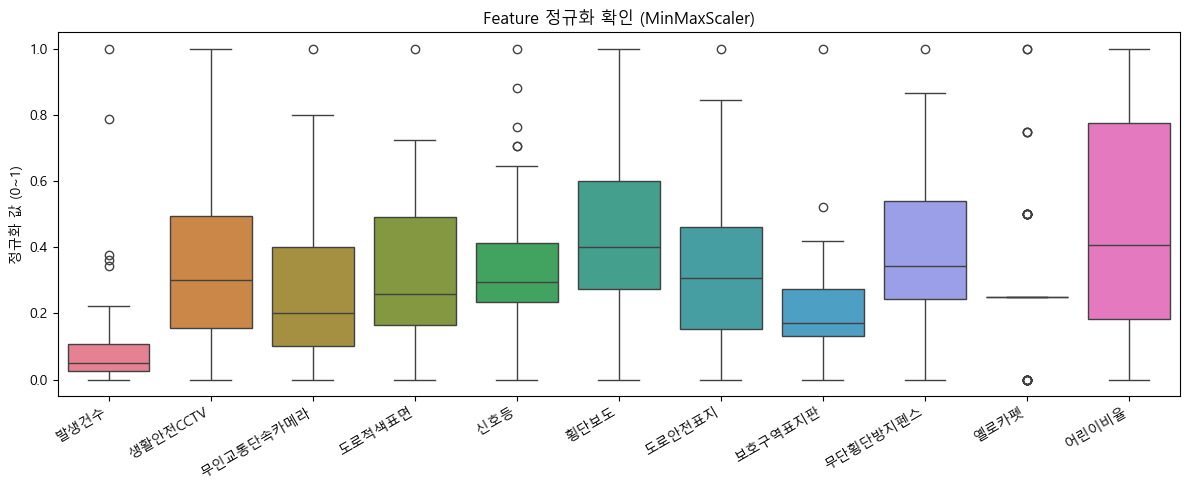

In [9]:
# 정규화 확인
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

sns.boxplot(data=schoolzone_scaled[all_feature_cols], ax=ax)

ax.set_title('Feature 정규화 확인 (MinMaxScaler)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_ylabel('정규화 값 (0~1)')

plt.tight_layout()
plt.show()

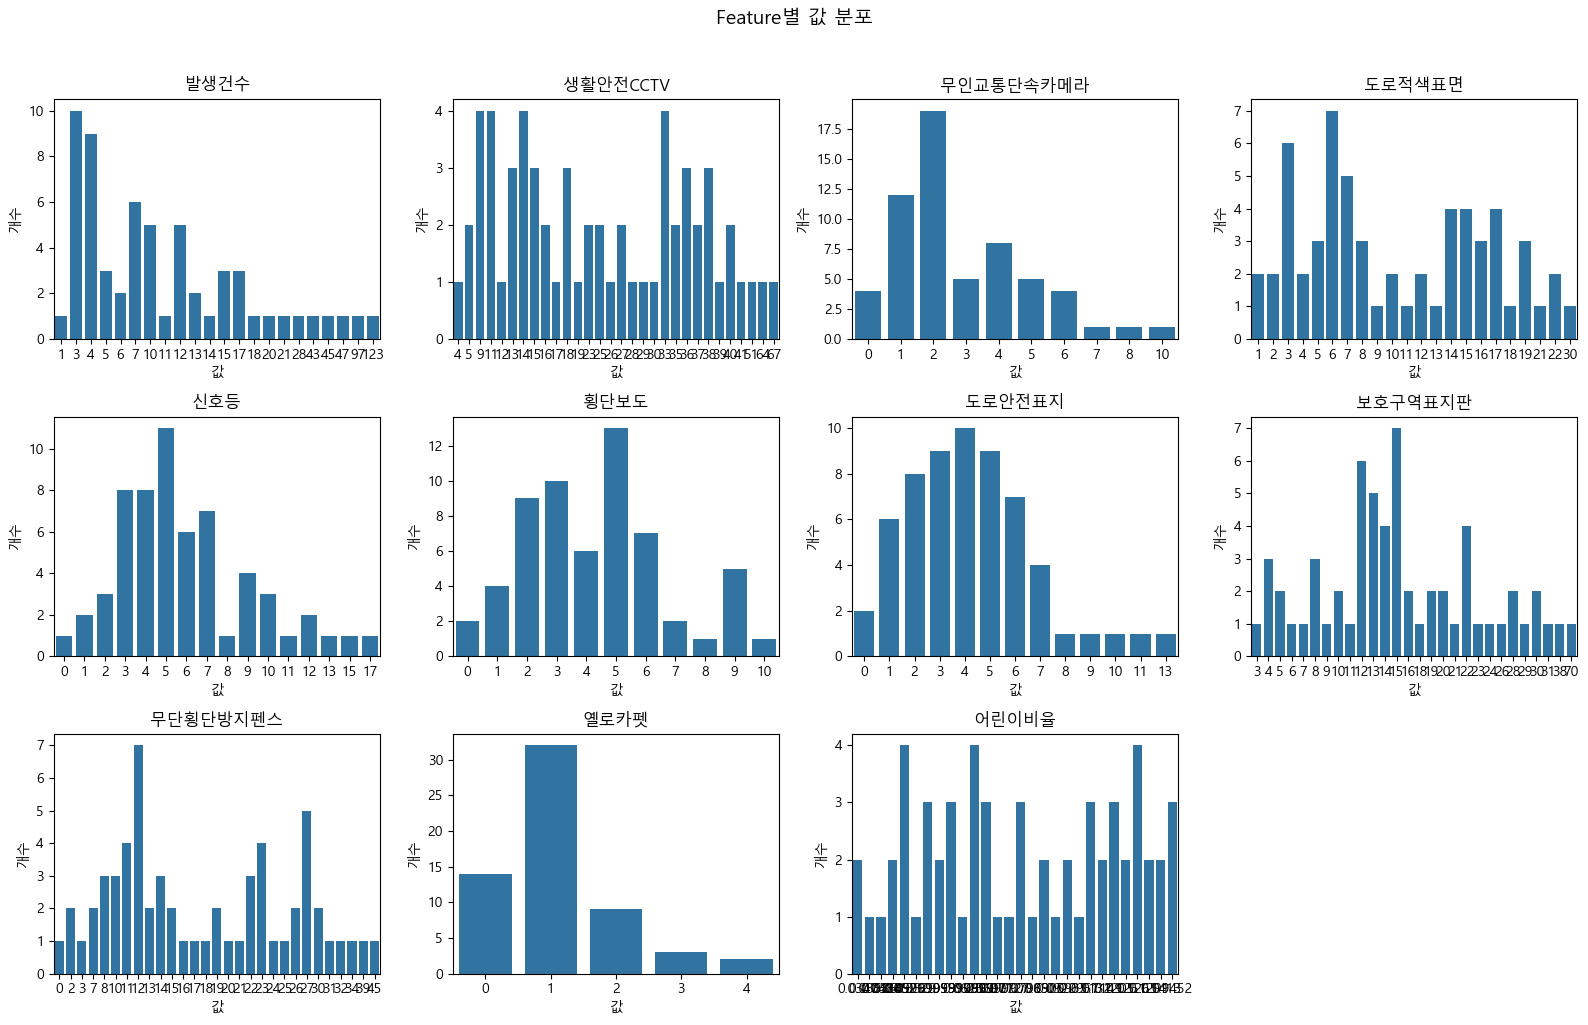

In [10]:
# 값 분포 확인
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(all_feature_cols):
    value_counts = schoolzone[col].value_counts().sort_index()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('값')
    axes[i].set_ylabel('개수')

# 남는 subplot 숨기기
for j in range(len(all_feature_cols), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Feature별 값 분포', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

일단 가장 높은 순부터 정렬

In [11]:

schoolzone['안전점수'].describe()

count     60.000000
mean      65.242333
std       17.390771
min        0.000000
25%       57.200000
50%       66.375000
75%       72.895000
max      100.000000
Name: 안전점수, dtype: float64